In [1]:
import os
import numpy as np
import pandas as pd
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Required deep learning libraries
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,Dense, Flatten,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import keras
from tensorflow.keras import Model


Using TensorFlow backend.


### image paths

In [3]:
trainCSV_Data = "../data/styles.csv"
trainImage    = "../data/images/"
testCSV_Data  = "../data/myntradataset/styles.csv"
testImage     = "../data/myntradataset/images/"

### reading csv data

In [4]:
traindata = pd.read_csv(trainCSV_Data,nrows=5000, error_bad_lines=False)
traindata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


In [5]:
# adding .jpg after id for every image
traindata['image'] = traindata['id'].map(lambda x: str(x) + '.jpg')

In [6]:
# concatenating subCategory+articleType=type
traindata['type']=traindata['subCategory']+" "+traindata['articleType']
# cleaning dataset
traindata.drop(['gender','masterCategory','baseColour','season','year','usage','productDisplayName','subCategory','articleType'],axis=1,inplace=True)

In [7]:
# final dataset
traindata.head()

,id,image,type
0,15970,15970.jpg,Topwear Shirts
1,39386,39386.jpg,Bottomwear Jeans
2,59263,59263.jpg,Watches Watches
3,21379,21379.jpg,Bottomwear Track Pants
4,53759,53759.jpg,Topwear Tshirts


In [8]:
print(f"Total data rows: {len(traindata)}")
print(f"Total number of equnique fashion type: {len(traindata['type'].unique())}")
print("Total number of fashion type which has value count less than 120: ",len(traindata.groupby("type").filter(lambda x : len(x)<100)))

Total data rows: 5000
Total number of equnique fashion type: 111
Total number of fashion type which has value count less than 120:  1746


In [9]:
traindata = traindata.groupby("type").filter(lambda x : len(x)>120)

<AxesSubplot:xlabel='type', ylabel='count'>

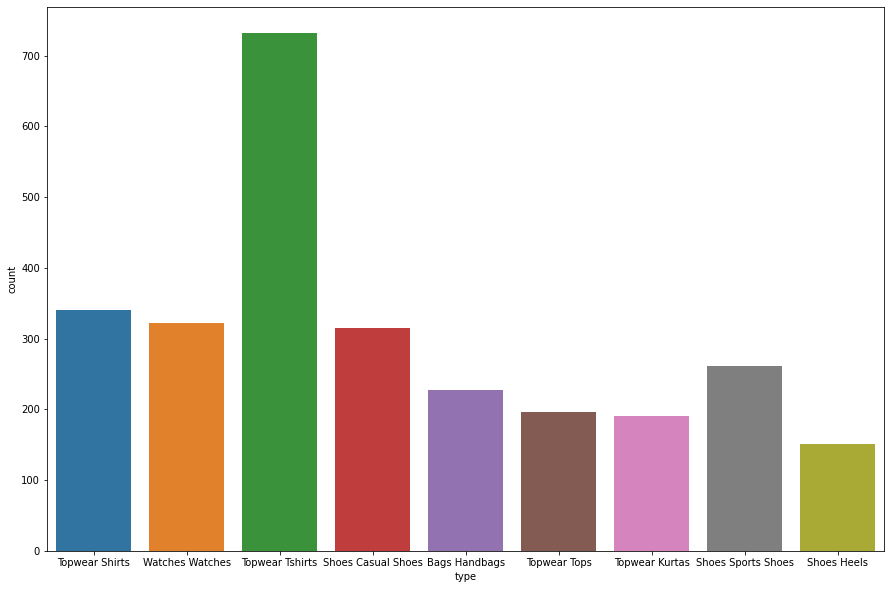

In [10]:
plt.figure(figsize=(15,10))
sns.countplot(traindata.type)

# sample images

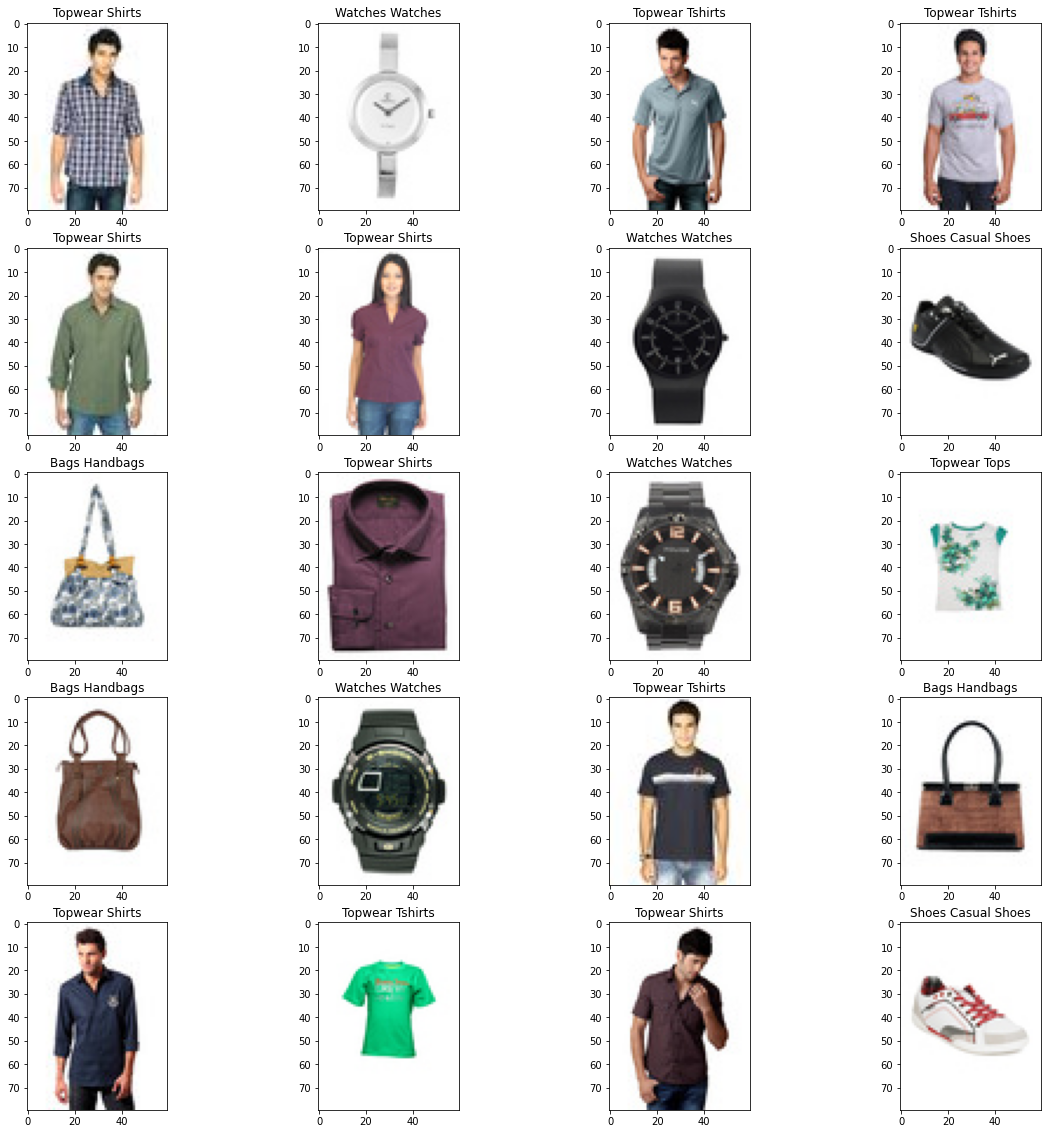

In [11]:
images, labels = traindata[:20]["image"].tolist(), traindata[:20]["type"].tolist()
# Plot the image grid
plt.figure(figsize = (20,20))
for i in range(20):
    plt.subplot(5,4,i+1)
    img = cv2.imread(trainImage + images[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(labels[i])

In [12]:
train,test = train_test_split(traindata,test_size=0.2, random_state=42)

In [13]:
print("shape of training data: ", train.shape)
print("shape of test data: ", test.shape)

shape of training data:  (2187, 3)
shape of test data:  (547, 3)


In [25]:
BATCH_SIZE   = 64
EPOCHS       = 100
TARGET_SIZE  = 32
num_features = 128
num_labels   = 9
batch_size   = 64

### Augment Image Data

In [26]:
train_datagen = ImageDataGenerator(validation_split                = 0.2,
                                    width_shift_range = 0.2,height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.3,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

In [27]:
train_generator = train_datagen.flow_from_dataframe(train,
                         directory   = os.path.join(trainImage),
                         subset      = "training",
                         x_col       = "image",
                         y_col       = "type",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size  = BATCH_SIZE,
                         class_mode  = "sparse")


Found 1750 validated image filenames belonging to 9 classes.


In [28]:
validation_datagen = ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(train,
                       directory    = os.path.join(trainImage),
                       subset       = "validation",
                       x_col        = "image",
                       y_col        = "type",
                       target_size  = (TARGET_SIZE, TARGET_SIZE),
                       batch_size   = BATCH_SIZE,
                       class_mode   = "sparse")

Found 437 validated image filenames belonging to 9 classes.


Found 1 validated image filenames belonging to 1 classes.


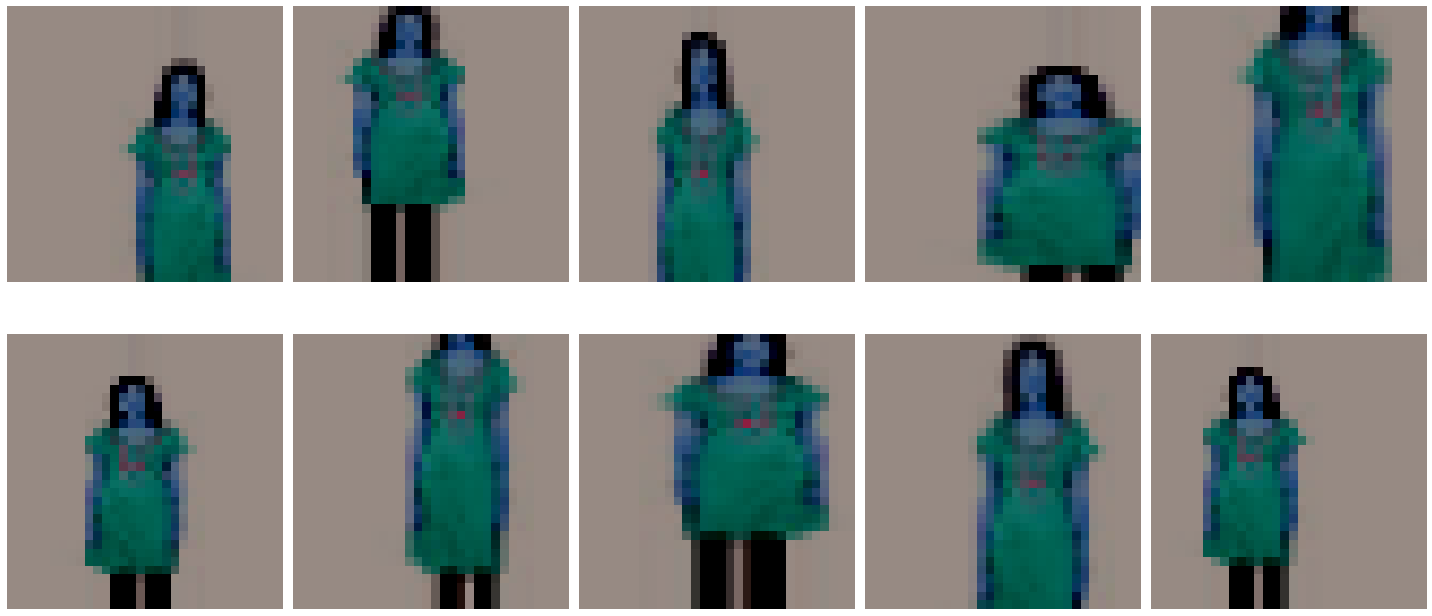

In [29]:
generator = train_datagen.flow_from_dataframe(traindata.iloc[20:21],
                         directory     = os.path.join(trainImage),
                         x_col         = "image",
                         y_col         = "type",
                         target_size   = (TARGET_SIZE, TARGET_SIZE),
                         batch_size    = BATCH_SIZE,
                         class_mode    = "sparse")

aug_images = [generator[0][0][0]/255 for i in range(10)]
fig, axes  = plt.subplots(2, 5, figsize = (20, 10))
axes       = axes.flatten()

for img, ax in zip(aug_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

### callback function

In [30]:
ACCURACY_THRESHOLD = 0.9

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > ACCURACY_THRESHOLD):
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

# Instantiate a callback object
callbacks = myCallback()

In [31]:
# Loss curve
def lossCurve(history):
  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
    

In [32]:
# accuracy curve
def accuracyCurve(history):
  plt.plot(history.history['acc'],'r',linewidth=3.0) 
  plt.plot(history.history['val_acc'],'b',linewidth=3.0) 
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18) 
  plt.xlabel('Epochs ',fontsize=16) 
  plt.ylabel('Accuracy',fontsize=16) 
  plt.title('Accuracy Curves',fontsize=16)

In [33]:
# Curve gride
def plotSummary(history):
    plt.figure(figsize=[18,10]) 
    plt.subplot(121)
    # Model summary of loss and accuray during training with data
    lossCurve(history)
    #Plot the Accuracy Curves
    plt.subplot(122)
    accuracyCurve(history)

#  Model

In [53]:
def VGG16_Model():
    
    vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(TARGET_SIZE, TARGET_SIZE,3))

    for layer in vgg_model.layers:
        layer.trainable = False
    x = Flatten()(vgg_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_labels, activation='softmax')(x)
    
    model = Model(vgg_model.input, x)
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [54]:
model3 = VGG16_Model()
#model3.summary()

Epoch 1/5
28/28 [==============================] - 22s 768ms/step - loss: 1.6701 - acc: 0.5714 - val_loss: 1.6210 - val_acc: 0.6064
Epoch 2/5
28/28 [==============================] - 22s 784ms/step - loss: 1.4615 - acc: 0.5989 - val_loss: 1.4588 - val_acc: 0.6224
Epoch 3/5
28/28 [==============================] - 21s 758ms/step - loss: 1.3207 - acc: 0.5943 - val_loss: 1.8419 - val_acc: 0.5767
Epoch 4/5
28/28 [==============================] - 21s 761ms/step - loss: 1.1954 - acc: 0.6143 - val_loss: 1.4299 - val_acc: 0.6064
Epoch 5/5
28/28 [==============================] - 22s 788ms/step - loss: 1.1037 - acc: 0.6383 - val_loss: 1.5104 - val_acc: 0.6224


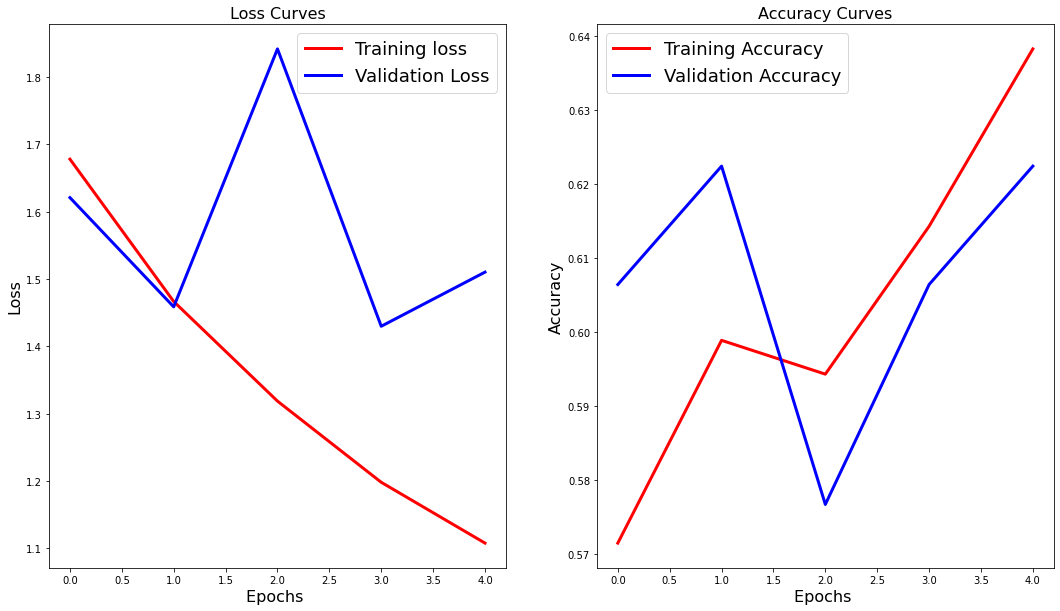

In [80]:
history3 = model3.fit( train_generator,epochs=5,verbose=1,validation_data = validation_generator,batch_size = BATCH_SIZE,callbacks=[callbacks])
plotSummary(history3)

In [ ]:
# all the class labels
classes = {v: k for k, v in train_generator.class_indices .items()} 

# predition

In [56]:
testImage = "../data/TEST/tshirt.png"

In [59]:
# image = Image.open(testImage)
# image = image.resize((TARGET_SIZE, TARGET_SIZE))
# image = np.expand_dims(image, axis = 0)
# prediction = np.argmax(model3.predict(image))

Text(0.5, 1.0, 'Watches Watches')

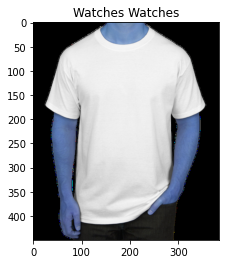

In [79]:
img = cv2.imread(testImage)
plt.imshow(img)
img.resize((TARGET_SIZE, TARGET_SIZE,3))
image = np.expand_dims(img, axis=0)
pred = model3.predict(image)
plt.title(classes[np.argmax(pred)])

In [73]:
pred

array([[6.8428385e-04, 2.6606594e-17, 6.1679381e-23, 2.7672489e-25,
        1.5709679e-13, 2.7844859e-19, 2.5049484e-08, 1.7788919e-08,
        9.9931574e-01]], dtype=float32)

'Watches Watches'